# Deep Convolutional Generative Adversarial Network

In [1]:
from __future__ import print_function
import argparse
import os
import random
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
%matplotlib inline
from IPython.display import HTML

In [2]:
import torch
import torch.nn as nn
import torch.nn.parallel
import torch.backends.cudnn as cudnn
import torch.utils.data

In [3]:
import torchvision.datasets as datasets
import torchvision.transforms as transforms
import torchvision.utils as vutils

In [4]:
# set random seed for reproducibility
manual_seed = 1
torch.manual_seed(manual_seed)
random.seed(manual_seed)

## Set Arguments

In [5]:
# root directory for dataset
data_root = 'data/celeba'

# number of workers for data loader
workers = 2

# batch size during training
batch_size = 128

# spatial size of training images
# all images will be resized to this size using a transformer
image_size = 64

# number of channels in the training images
n_channels = 3

# size of Z latent vector (i.e. size of generator input)
n_zlvector = 100

# size of feature maps in generator
n_fgenerator = 64

# size of feature maps in discriminator
n_fdiscriminator = 64

# number of training epochs
n_epochs = 5

# learning rate for optimizers
lr = 0.0002

# beta1 hyper-param for Adam optimizers
beta1 = 0.5
beta2 = 0.999

# number of GPUs availabele
n_gpu = 1

## Configure Data Loader

In [6]:
# we can use an image folder dataset the way we have it setup
data_loader = torch.utils.data.DataLoader(
    datasets.ImageFolder(root = data_root,
                         transform = transforms.Compose([
                             transforms.Resize(image_size),
                             transforms.CenterCrop(image_size),
                             transforms.ToTensor(),
                             transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
                         ])),
                         batch_size = batch_size,
                         shuffle = True,
                         num_workers = workers
)

In [7]:
# decide which device we want to run on
device = torch.device('cuda:0' if (torch.cuda.is_available() and n_gpu > 0) else 'cpu')

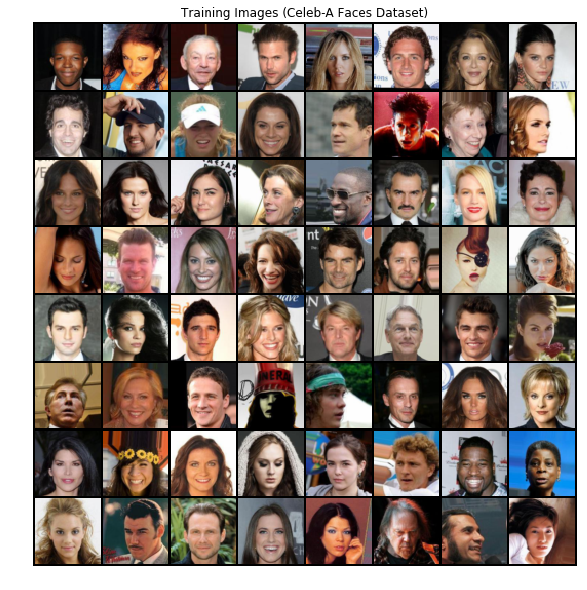

In [8]:
real_batch = next(iter(data_loader))
plt.figure(figsize=(10,10))
plt.axis('off')
plt.title('Training Images (Celeb-A Faces Dataset)')
plt.imshow(np.transpose(vutils.make_grid(real_batch[0].to(device)[:64], padding=2, normalize=True).cpu(), (1, 2, 0)))
plt.show()

## Build DCGAN Architecture

<img src='images/dcgan-architecture.png' width='75%'/>

In [9]:
# custome weights initialization called on the generator and discriminator
def weights_init_normal(m):
    classname = m.__class__.__name__
    if classname.find('conv') != -1:
        torch.nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm2d') != -1:
        torch.nn.init.normal_(m.weight.data, 1.0, 0.02)
        torch.nn.init.constant_(m.bias.data, 0.0)

## Generator

In [10]:
class Generator(nn.Module):
    
    def __init__(self, n_gpu):
        super(Generator, self).__init__()
        
        self.n_gpu = n_gpu
        self.conv_blocks = nn.Sequential(
            nn.ConvTranspose2d(n_zlvector, n_fgenerator * 8, kernel_size=4, stride=1, padding=0, bias=False),
            nn.BatchNorm2d(n_fgenerator * 8),
            nn.ReLU(True),
            
            nn.ConvTranspose2d(n_fgenerator * 8, n_fgenerator * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(n_fgenerator * 4),
            nn.ReLU(True),
            
            nn.ConvTranspose2d(n_fgenerator * 4, n_fgenerator * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(n_fgenerator * 2),
            nn.ReLU(True),
            
            nn.ConvTranspose2d(n_fgenerator * 2, n_fgenerator, 4, 2, 1, bias=False),
            nn.BatchNorm2d(n_fgenerator),
            nn.ReLU(True),
            nn.ConvTranspose2d(n_fgenerator, n_channels, 4, 2, 1, bias=False),
            nn.Tanh(),
        )
    
    def forward(self, z):
        img = self.conv_blocks(z)
        return img

## Discriminator

In [11]:
class Discriminator(nn.Module):
    
    def __init__(self, n_gpu):
        super(Discriminator, self).__init__()
        self.n_gpu = n_gpu
        self.model = nn.Sequential(
            nn.Conv2d(n_channels, n_fdiscriminator, 4, 2, 1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
            
            nn.Conv2d(n_fdiscriminator, n_fdiscriminator*2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(n_fdiscriminator * 2),
            nn.LeakyReLU(0.2, inplace=True),
            
            nn.Conv2d(n_fdiscriminator*2, n_fdiscriminator*4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(n_fdiscriminator*4),
            nn.LeakyReLU(0.2, inplace=True),
            
            nn.Conv2d(n_fdiscriminator*4, n_fdiscriminator*8, 4, 2, 1, bias=False),
            nn.BatchNorm2d(n_fdiscriminator*8),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(n_fdiscriminator*8, 1, 4, 1, 0, bias=False),
            nn.Sigmoid(),
        )
    
    def forward(self, img):
        validity = self.model(img)
        return validity

#### Initialize the generator and discriminator

In [12]:
generator = Generator(n_gpu).to(device)
discriminator = Discriminator(n_gpu).to(device)

# handle multi-gpu if desired
if (device.type == 'cuda') and (n_gpu > 1):
    generator = nn.DataParallel(generator, list(range(n_gpu)))
    discriminator = nn.DataParallel(discriminator, list(range(n_gpu)))

In [13]:
# create batch of latent vectors to visualize the progression of the generator
fixed_noise = torch.randn(64, n_zlvector, 1, 1, device=device)

# establish convention for real and fake labels during training
real_label = 1
fake_label = 0

## Loss Function

In [14]:
adversarial_loss = nn.BCELoss()
if (device.type == 'cuda'): adversarial_loss.cuda()

## Optimizer

In [15]:
optimizer_G = torch.optim.Adam(generator.parameters(), lr=lr, betas=(beta1, beta2))
optimizer_D = torch.optim.Adam(discriminator.parameters(), lr=lr, betas=(beta1, beta2))

## Training The [Network](https://arxiv.org/pdf/1511.06434)

#### Initialize weights

In [16]:
generator.apply(weights_init_normal)

Generator(
  (conv_blocks): Sequential(
    (0): ConvTranspose2d(100, 512, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): ConvTranspose2d(512, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (4): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (7): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): ReLU(inplace=True)
    (9): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (10): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): ReLU(inplace=True)
    (12): ConvTranspose2d(64, 3, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (13): Tanh()

In [17]:
discriminator.apply(weights_init_normal)

Discriminator(
  (model): Sequential(
    (0): Conv2d(3, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
    (2): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): LeakyReLU(negative_slope=0.2, inplace=True)
    (5): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (6): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): LeakyReLU(negative_slope=0.2, inplace=True)
    (8): Conv2d(256, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (9): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): LeakyReLU(negative_slope=0.2, inplace=True)
    (11): Conv2d(512, 1, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (12): Sigmoid()
  )
)

In [18]:
img_list = []
g_loss_to_display = []
d_loss_to_display = []
iters = 0

for epoch in range(n_epochs):
    for i, imgs in enumerate(data_loader):
        
        # ---------------------
        #  Train Discriminator: maximize log(D(x)) + log(1 - D(G(z)))
        # ---------------------
        
        # train with all-real batch
        discriminator.zero_grad()
        real_cpu = imgs[0].to(device)
        batch_size = real_cpu.size(0)
        label = torch.full((batch_size,), real_label, device=device)
        
        # forward pass real batch through the discriminator
        validity = discriminator(real_cpu).view(-1)
        real_loss = adversarial_loss(validity, label)
        real_loss.backward()
        d_x = validity.mean().item()
        
        # train with all-fake batch
        # generate batch of latent vectors
        noise = torch.randn(batch_size, n_zlvector, 1, 1, device=device)
        
        # generate fake image batch with the generator
        fake = generator(noise)
        label.fill_(fake_label)
        
        # classify all fake batch with descriminator
        validity = discriminator(fake.detach()).view(-1)
        fake_loss = adversarial_loss(validity, label)
        fake_loss.backward()
        d_g_z1 = validity.mean().item()
        
        # add the gradients from the all-real and all-fake batches
        d_loss = real_loss + fake_loss
        optimizer_D.step()
        
        # ---------------------
        #  Train Generator: maximize log(D(G(z)))
        # ---------------------
        
        generator.zero_grad()
        label.fill_(real_label) # fake labelas are real for generator cost
 
        validity = discriminator(fake).view(-1)
        g_loss = adversarial_loss(validity, label)
        g_loss.backward()
        d_g_z2 = validity.mean().item()
        optimizer_G.step()
        
        # output training stats
        if i % 50 == 0:
            print('[Epoch %d/%d] [Batch %d/%d] [Discriminator loss: %f] [Generator loss: %f] - D(x): %.4f D(G(z)): %.4f / %.4f'
                 % (epoch, n_epochs, i, len(data_loader),
                    d_loss.item(), g_loss.item(), d_x, d_g_z1, d_g_z2))
            
        # save losses for plotting later
        d_loss_to_display.append(d_loss.item())
        g_loss_to_display.append(g_loss.item())

        # check how the generator is doing by saving the generator's output on fixed noise
        if (iters % 500 == 0) or ((epoch == n_epochs-1) and (i == len(data_loader)-1)):
            with torch.no_grad():
                fake = generator(fixed_noise).detach().cpu()
            img_list.append(vutils.make_grid(fake, padding=2, normalize=True))
        
        iters += 1

[Epoch 0/5] [Batch 0/30] [Discriminator loss: 1.246353] [Generator loss: 2.223937] - D(x): 0.4669 D(G(z)): 0.3672 / 0.1123
[Epoch 1/5] [Batch 0/30] [Discriminator loss: 0.106346] [Generator loss: 8.362986] - D(x): 0.9438 D(G(z)): 0.0099 / 0.0003
[Epoch 2/5] [Batch 0/30] [Discriminator loss: 0.760314] [Generator loss: 10.167055] - D(x): 0.9807 D(G(z)): 0.4845 / 0.0001
[Epoch 3/5] [Batch 0/30] [Discriminator loss: 0.674621] [Generator loss: 6.409492] - D(x): 0.9275 D(G(z)): 0.3808 / 0.0058
[Epoch 4/5] [Batch 0/30] [Discriminator loss: 0.635527] [Generator loss: 2.769181] - D(x): 0.8033 D(G(z)): 0.3223 / 0.0695


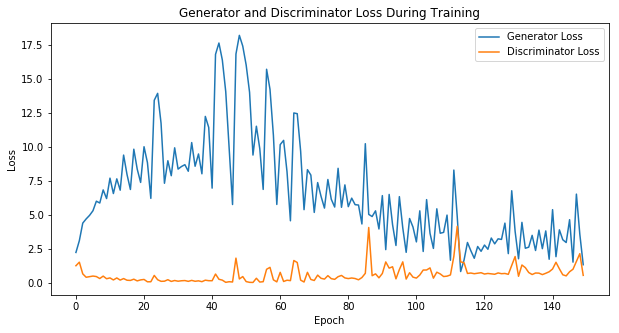

In [19]:
plt.figure(figsize=(10,5))
plt.title("Generator and Discriminator Loss During Training")
plt.plot(g_loss_to_display, label="Generator Loss")
plt.plot(d_loss_to_display, label="Discriminator Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
# plt.savefig('./images/dcgan/final_loss.png')
plt.show()

## Final GAN Images

In [20]:
%%capture
fig = plt.figure(figsize=(8,8))
plt.axis("off")
ims = [[plt.imshow(np.transpose(i,(1,2,0)), animated=True)] for i in img_list]
ani = animation.ArtistAnimation(fig, ims, interval=1000, repeat_delay=1000, blit=True)

HTML(ani.to_jshtml())

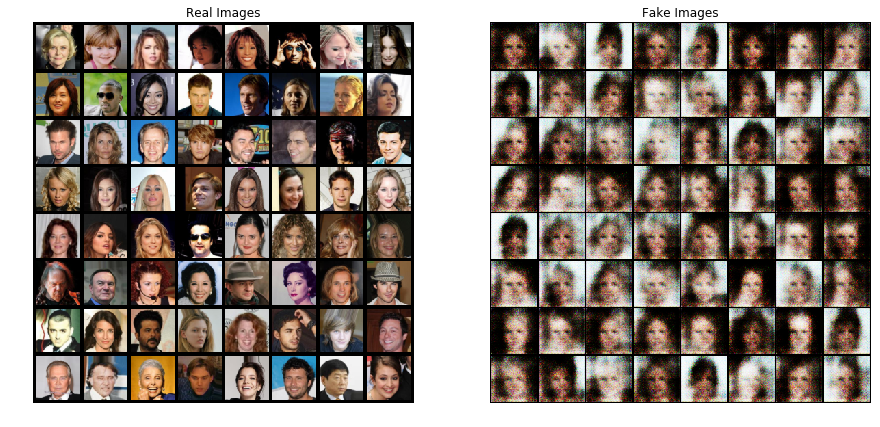

In [21]:
# grab a batch of real images from the data loader
real_batch = next(iter(data_loader))

# plot the real images
plt.figure(figsize=(15,15))
plt.subplot(1,2,1)
plt.axis("off")
plt.title("Real Images")
plt.imshow(np.transpose(vutils.make_grid(real_batch[0].to(device)[:64], padding=5, normalize=True).cpu(),(1,2,0)))

# plot the fake images from the last epoch
plt.subplot(1,2,2)
plt.axis("off")
plt.title("Fake Images")
plt.imshow(np.transpose(img_list[-1],(1,2,0)))
plt.show()

---